# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
import math

In [2]:
# Function that calculates the sum of avg_cost_min with the highest predicted probabilities
# prediction is the predicted probabilities from the model.
# The argument testSet should be the unstandardized testset

def avgCostSum(prediction, y_testSet, X_testSet):
    #Get an array of sorted predictions in descending order
    index = np.argsort(prediction)[::-1]
    #Select the sorted avg_cost_min column from the unstandardized dataframe, then get the 20 highest
    avg_cost_min = X_testSet.iloc[index,].join(y_testSet.iloc[index])
    avg_cost_min = avg_cost_min[["average cost min", "target"]][0:20]
    #Return the sum of the top 20 for those that were correctly predicted
    return avg_cost_min[avg_cost_min["target"]==1]["average cost min"].sum()

# Read the data

In [3]:
df = pd.read_csv("../datasets/assignment1_train.csv")
df.head()

,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,...,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target,id
0,F,50.0,20/05/98,29.200000,2.0,Play 100,BS210,62.0,153.000000,185.0,...,OK,0.150531,0.246536,0.706735,0.046729,0.203034,F,F,0,K262360
1,M,25.0,16/12/96,46.533333,1.0,CAT 100,ASAD90,146.0,718.800000,98.0,...,OK,0.188988,0.780710,0.178886,0.040404,0.273249,F,F,1,K170160
2,F,46.0,27/08/97,38.066667,1.0,CAT 50,WC95,160.0,322.800000,7.0,...,OK,0.239300,0.722633,0.277367,0.000000,0.205025,F,F,0,K331610
3,F,59.0,13/07/98,27.400000,1.0,CAT 50,BS110,84.0,317.400001,57.0,...,OK,0.221467,0.662492,0.337508,0.000000,0.050090,F,F,0,K332460
4,F,25.0,08/01/99,21.433333,1.0,Play 300,WC95,14.0,309.600000,326.0,...,OK,0.107509,0.321896,0.663132,0.014972,0.090509,F,F,0,K394220


In [4]:
# We can drop the column id: it is unique to each customer and has no predictive value
assert len(df.id.unique()) == len(df)
df_clean = df.drop(["id"], axis=1)

# Convert Connect date into number of days
date_col = pd.to_datetime(df_clean["Connect_Date"], format = '%d/%m/%y')
date_col.astype('int64')
df_clean["today"] = pd.Timestamp.today()
df_clean["Days_since_connected"] = df_clean["today"]-date_col
df_clean["Days_since_connected"] = df_clean["Days_since_connected"].dt.days
df_clean.drop(["today", "Connect_Date"], axis=1, inplace=True)

# Set the target as categorical
#df_clean['target'] = df_clean['target'].map({0:'retained', 1:'churned'}).astype('object')

In [5]:
df_clean.dtypes

Gender                     object
Age                       float64
L_O_S                     float64
Dropped_Calls             float64
tariff                     object
Handset                    object
Peak_calls_Sum            float64
Peak_mins_Sum             float64
OffPeak_calls_Sum         float64
OffPeak_mins_Sum          float64
Weekend_calls_Sum         float64
Weekend_mins_Sum          float64
International_mins_Sum    float64
Nat_call_cost_Sum         float64
AvePeak                   float64
AveOffPeak                float64
AveWeekend                float64
National_calls            float64
National mins             float64
AveNational               float64
All_calls_mins            float64
Dropped_calls_ratio       float64
Usage_Band                 object
Mins_charge               float64
call_cost_per_min         float64
actual call cost          float64
Total_call_cost           float64
Total_Cost                float64
Tariff_OK                  object
average cost m

# Exploration

## Categorical variables

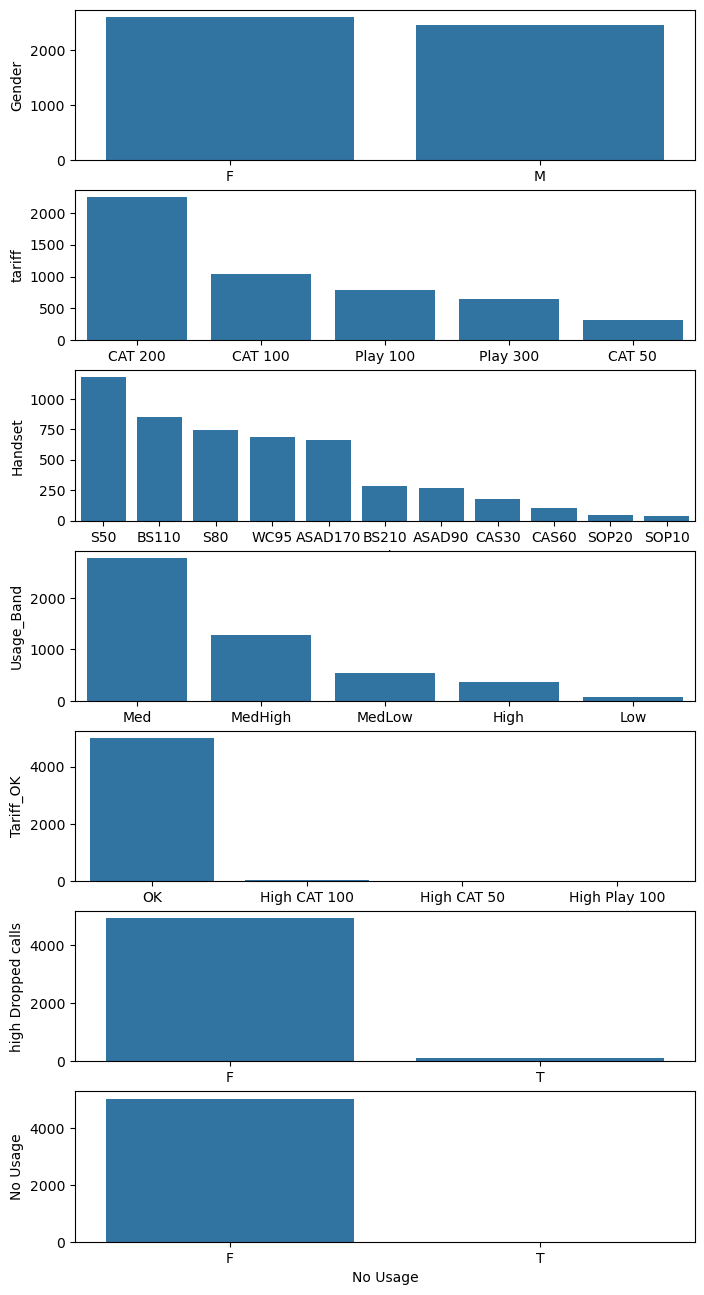

In [6]:
fig, ax = plt.subplots(
    nrows=len(df_clean.select_dtypes(include=['object']).columns),
    figsize=(8,16)
)

axix = 0
for _var in df_clean.select_dtypes(include=['object']).columns:
    sns.barplot(
        x=df_clean[_var].value_counts().index,
        y=df_clean[_var].value_counts(),
        ax=ax[axix]
    )
    ax[axix].set_ylabel(_var)
    axix += 1

## Continuous variables

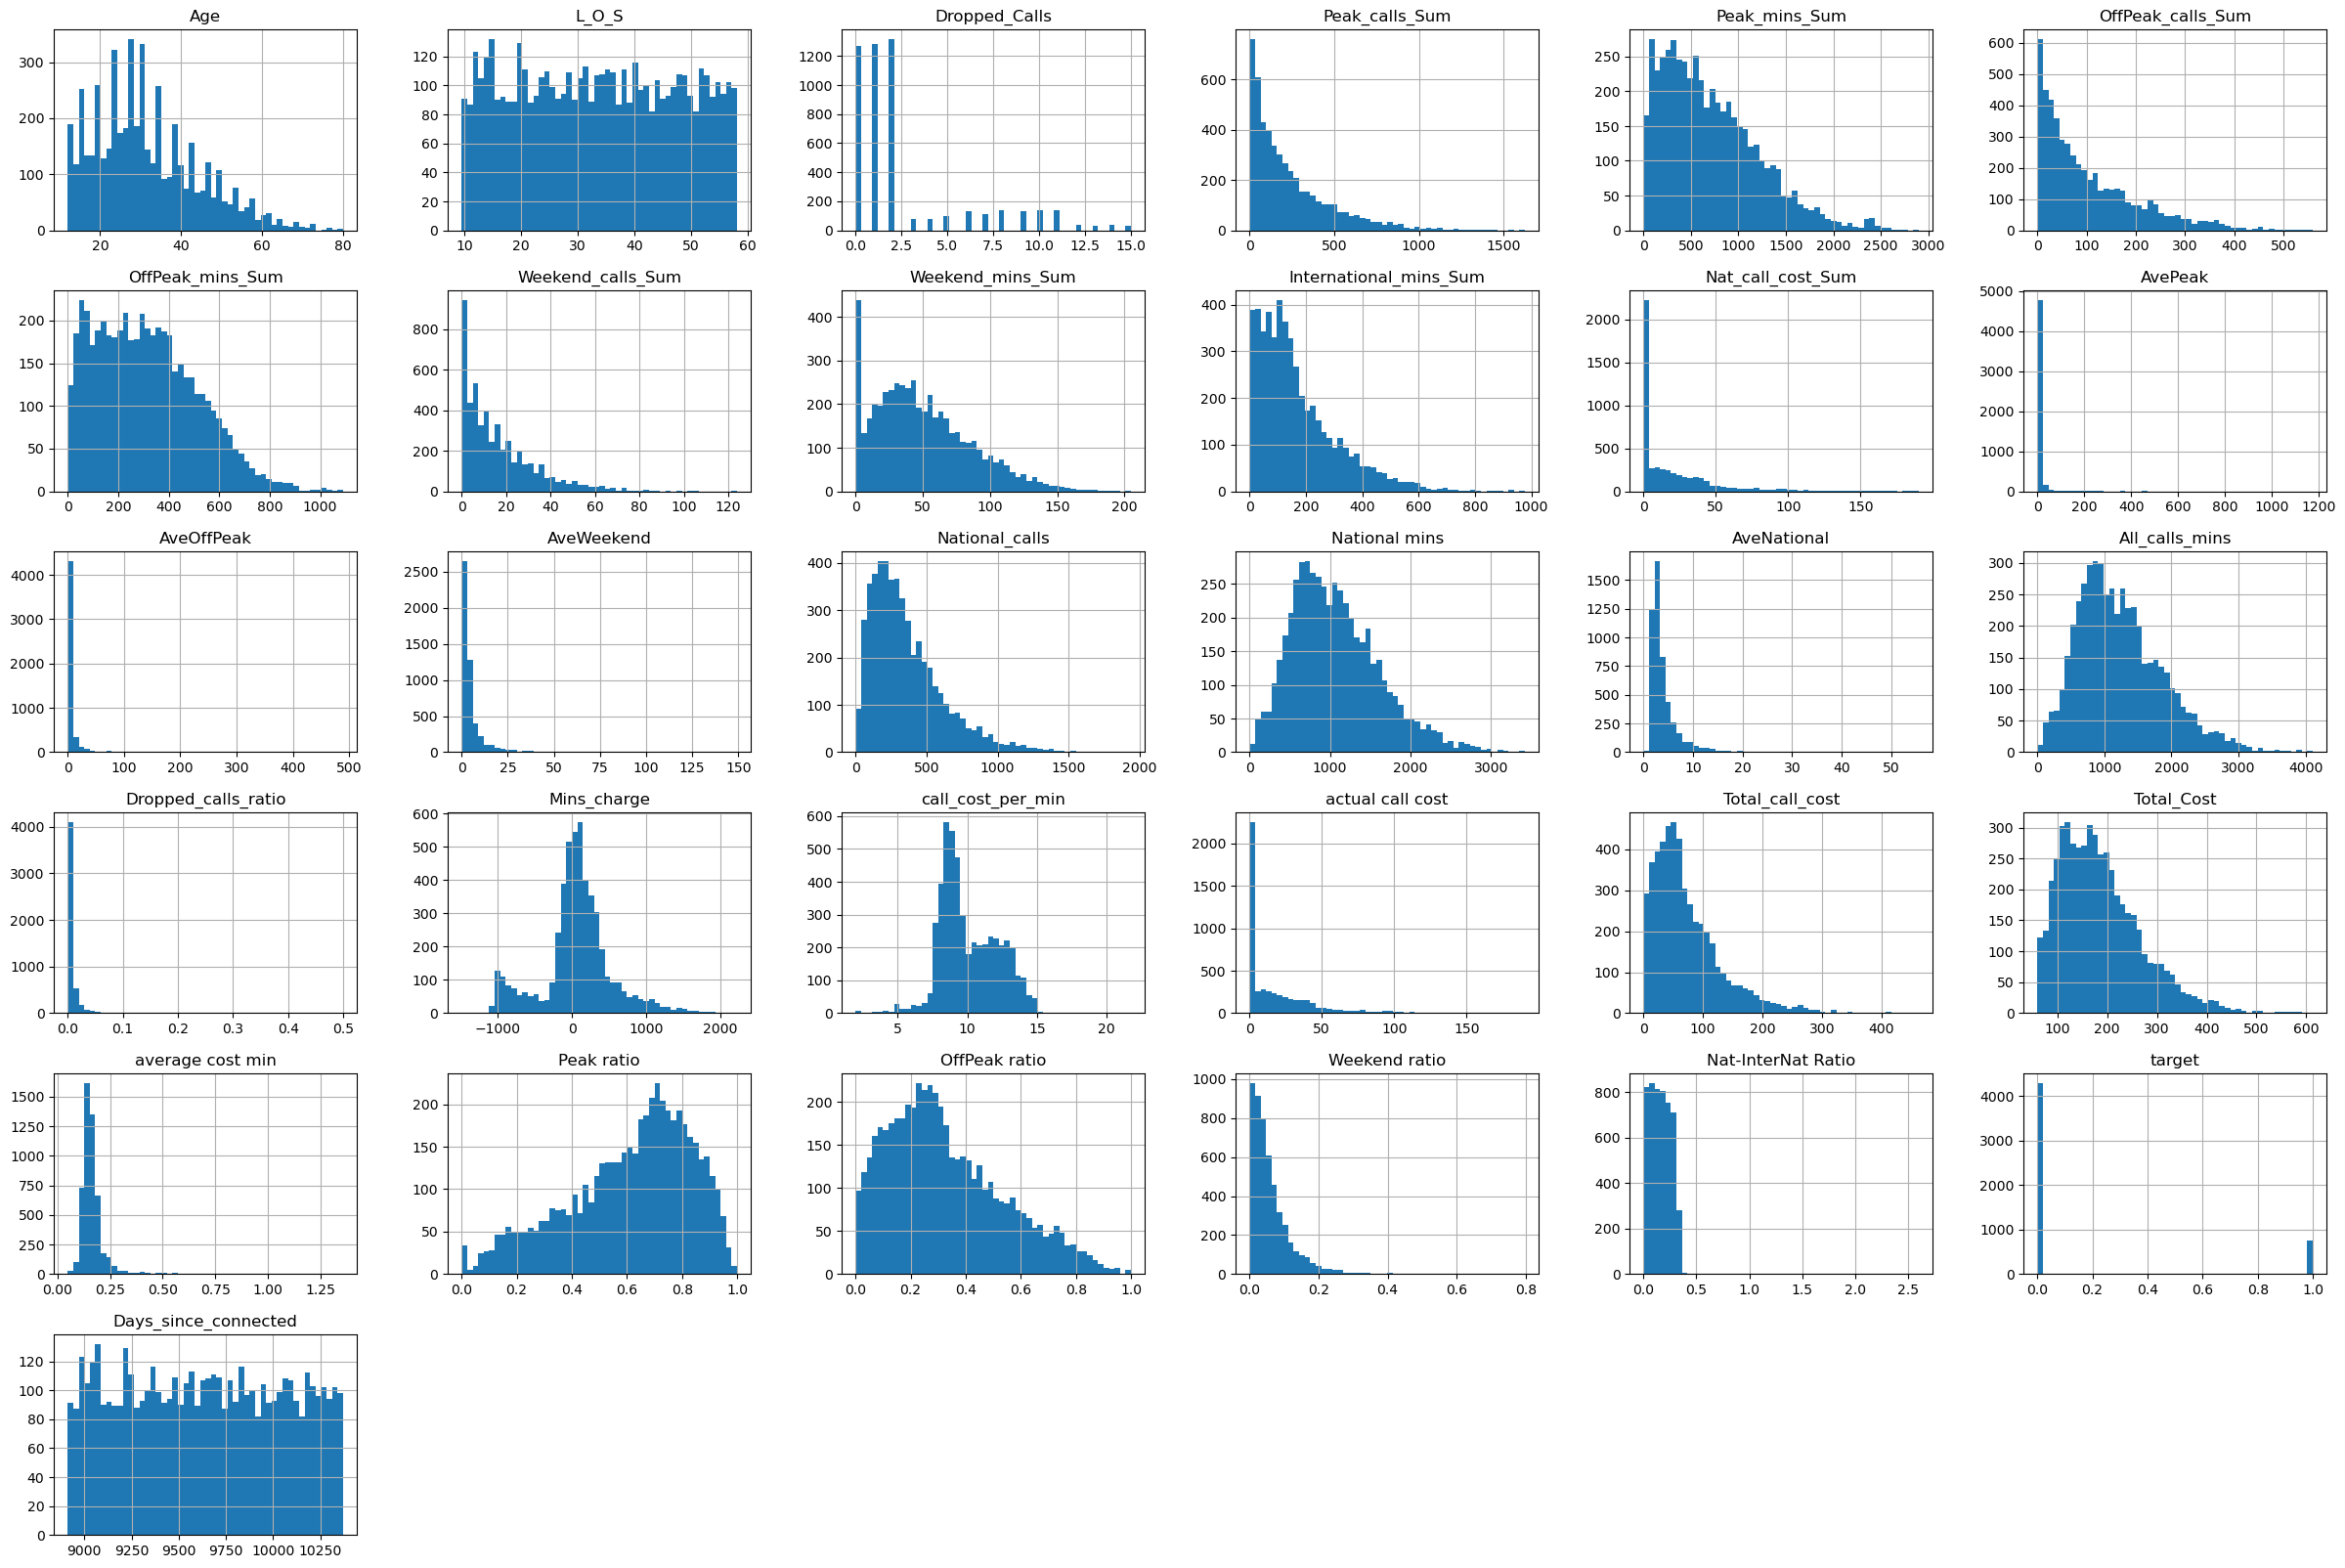

In [7]:
df_clean.select_dtypes(exclude=['object']).hist(bins=50, figsize=(30,20))
plt.show()

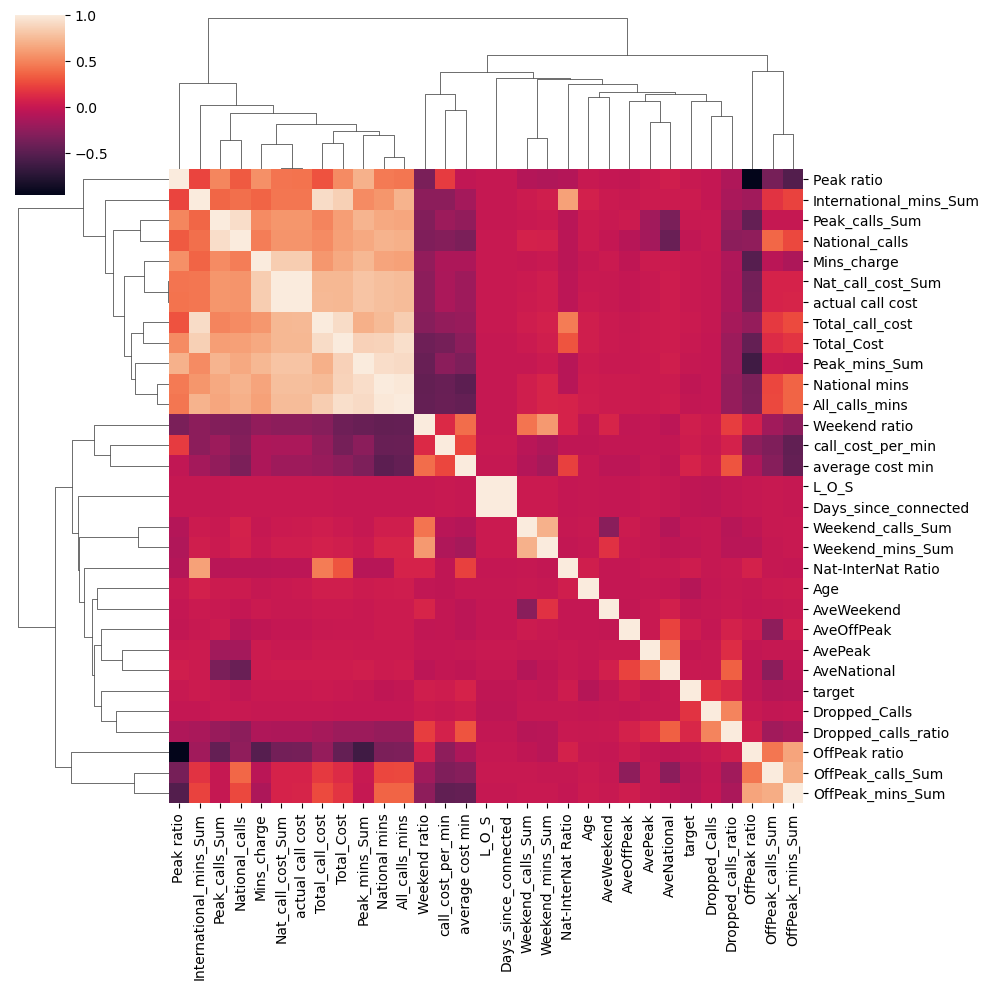

In [8]:
sns.clustermap(
    df_clean.select_dtypes(exclude=['object']).corr()
)

In [15]:
y = df_clean['target']
X = df_clean.drop(['target'], axis=1, inplace=False)

continuous = df_clean._get_numeric_data().columns.drop('target').tolist()
categorical = df_clean.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Modelling
## Transformations

In [16]:
# Save untransformed data for later
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

# Continuous Transformations
cts_pipe = Pipeline([
    ('ImputeContinuous', SimpleImputer(strategy="median")),
    #('StandardScaler', StandardScaler())
    ])

# Categorical Transformations
cat_pipe = Pipeline([
    ('OneHot', OneHotEncoder(handle_unknown='ignore'))
    ])

# Apply to columns
t = ColumnTransformer(
    [
    ("cts", cts_pipe, continuous),
    ("cat", cat_pipe, categorical)
    ])

# All trasnformations. Add any here that would apply to both continuous and categorical
final_pipeline = Pipeline([
    ('columns', t),
    #('PCA', PCA())
    ])


X_train = final_pipeline.fit_transform(X_train)
X_test= final_pipeline.transform(X_test)


In [17]:
#Save features names for feature improtance later in analysis
features = final_pipeline.named_steps["columns"].transformers_[1][1].named_steps["OneHot"].feature_names_in_
features_cat = final_pipeline.named_steps["columns"].transformers_[1][1].named_steps["OneHot"].get_feature_names_out(features)

In [18]:
features_cts =final_pipeline.named_steps["columns"].transformers_[0][2]

In [19]:
feature_names = features_cts+ features_cat.tolist()

<h4> Print out the maximum possible value for top 20 score

In [20]:
x = X_test_raw.join(y_test)
#Save the top 20 threshhold for later
top_20_thresh = (x[x["target"] ==1 ][["average cost min", "target"]].sort_values(by = "average cost min", ascending = False)[0:20].min().iloc[0])
#Save the sum of the top 20
x = x[x["target"] ==1 ][["average cost min", "target"]].sort_values(by = "average cost min", ascending = False)[0:20].sum()
max_target=(x.iloc[0])
print(max_target)

6.896127


## Modelling

In [21]:
models = []
models.append(('LR  ', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LRW ', LogisticRegression(solver='lbfgs', max_iter=1000, class_weight="balanced")))
models.append(('RF  ', RandomForestClassifier()))
models.append(('RFW ', RandomForestClassifier(class_weight="balanced")))
models.append(('DT  ', DecisionTreeClassifier(class_weight="balanced")))
models.append(('DTW ', DecisionTreeClassifier(class_weight="balanced")))
models.append(('GB  ', GradientBoostingClassifier(n_estimators = 100, learning_rate =0.2, max_depth=3, random_state=42)))
models.append(('XGB ', XGBClassifier()))
models.append(('XGBW', XGBClassifier(scale_pos_weight=6)))
models.append(('GNB', GaussianNB()))
models.append(('CNNs', MLPClassifier(hidden_layer_sizes=(200,), max_iter=1000, alpha=1e-6,
                        solver='adam', tol=1e-6, random_state=1,
                        learning_rate_init=.1)))
models.append(('SVM', SVC(kernel='rbf', C=5.0, probability=True)))
models.append(('catboost', CatBoostClassifier(iterations=100, 
                                    learning_rate=0.2,  
                                    depth=6, 
                                    loss_function='Logloss', 
                                    eval_metric='AUC',  
                                    random_state=42, verbose=1000,  allow_writing_files=False)))
b_c=[
    ('RFW ', RandomForestClassifier(class_weight="balanced")),
    ('SVM', SVC(kernel='rbf', C=5.0, probability=True)),
    ('XGBW', XGBClassifier(scale_pos_weight=6)),
    ('GB  ', GradientBoostingClassifier(n_estimators = 100, learning_rate =0.05, max_depth=3, random_state=42))
]
m_c= XGBClassifier(scale_pos_weight=6)
models.append(('Stacking', StackingClassifier(estimators=b_c, final_estimator=m_c, cv=5)))

results = []
print("\tAUC\tTop20\tAccuracy\tPrecision\tRecall")
for name, model in models:
    model.fit(X_train, y_train)  # Fit without sample weights
    y_pred = model.predict_proba(X_test)[:,1]
    cat_preds = [round(value) for value in y_pred]
    auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, cat_preds)
    precision = precision_score(y_test,cat_preds)
    recall = recall_score(y_test,cat_preds)
    top20 = avgCostSum(y_pred, y_test, X_test_raw)
    results.append(
        [name, auc, top20, accuracy, precision, recall]
    )
    print(f"{name}\t{auc}\t{top20}\t{accuracy}\t{precision}\t{recall}")

	AUC	Top20	Accuracy	Precision	Recall


/Users/deboutte/Bioinf/miniconda3/envs/advan_1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR  	0.6400571131879543	1.686849	0.848364717542121	0.5	0.013071895424836602


/Users/deboutte/Bioinf/miniconda3/envs/advan_1/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LRW 	0.6771501435465151	1.549415	0.6590683845391476	0.246684350132626	0.6078431372549019
RF  	0.9191176470588234	2.8354889999999995	0.9157581764122894	0.7463768115942029	0.673202614379085
RFW 	0.930559373282023	2.645832	0.9117938553022795	0.7580645161290323	0.6143790849673203
DT  	0.7741318490012828	1.80408	0.889990089197225	0.6458333333333334	0.6078431372549019
DTW 	0.7845198827194428	2.1887079999999997	0.8939544103072349	0.6575342465753424	0.6274509803921569
GB  	0.9348619510109341	2.28072	0.9167492566897919	0.7412587412587412	0.6928104575163399
XGB 	0.9374350986500519	2.518612	0.9157581764122894	0.75	0.6666666666666666
XGBW	0.936877710585792	2.36834	0.9207135777998018	0.732484076433121	0.7516339869281046
GNB	0.9043697697147395	3.0287	0.8999008919722498	0.6733333333333333	0.6601307189542484


/Users/deboutte/Bioinf/miniconda3/envs/advan_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CNNs	0.5	1.422251	0.848364717542121	0.0	0.0


/Users/deboutte/Bioinf/miniconda3/envs/advan_1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM	0.5742471443406023	1.331868	0.848364717542121	0.0	0.0
0:	total: 67.2ms	remaining: 6.65s
99:	total: 459ms	remaining: 0us
catboost	0.9417338586524953	2.511032	0.9355797819623389	0.7857142857142857	0.7908496732026143
Stacking	0.9386949483843382	2.850034	0.9246778989098117	0.7058823529411765	0.8627450980392157


## Write results out

<h4> Idea to improve top 20 score </h4>
<p>Fit the model once to a the regular target as before, but also fit it again where the target is only considered a success if 
average cost min is above a certain threshold. Finally, compute a weighted average of the two probabilities. Seems to work rather 
well for extreme gradient boost especially. Doubles the top 20 score without sacrificing much AUC</p>

In [22]:
#this is an attempt to estimate the cutoff threshold percentile for the top 20 based on the training data
#train_test_ratio = (X_train.shape[0]/X_test.shape[0])
#t = X_train_raw.join(y_train)[["average cost min", "target"]]
#t = t[t["target"] == 1]["average cost min"]
#percentile = (t.shape[0]-20*train_test_ratio)/t.shape[0]*100
percentile = 90
avg_cost_thresh = np.percentile(X_train_raw["average cost min"], percentile)

print("Estimated Threshold: ", avg_cost_thresh)
print("Actual top 20 thresh:", top_20_thresh)

Estimated Threshold:  0.21461579999999997
Actual top 20 thresh: 0.209777


In [23]:
high_model_weight = 0.8
reg_model_weight = 1-high_model_weight
y_train_high = y_train*(X_train_raw["average cost min"]>=avg_cost_thresh)

In [24]:
#combining the above with oversampling improves top 20 score
oversample = SMOTE(random_state=42)
X_train_high, y_train_high = oversample.fit_resample(X_train, y_train_high)
X_train, y_train = oversample.fit_resample(X_train, y_train)


In [25]:
#restrict to fewer models for faster testing
models = []
models.append(('RF  ', RandomForestClassifier()))
models.append(('RFW ', RandomForestClassifier(class_weight="balanced")))
models.append(('GB  ', GradientBoostingClassifier(n_estimators = 100, learning_rate =0.2, max_depth=3, random_state=42)))
models.append(('XGB ', XGBClassifier()))
models.append(('XGBW', XGBClassifier(scale_pos_weight=6)))
models.append(('catboost', CatBoostClassifier(iterations=100, 
                                    learning_rate=0.2,  
                                    depth=6, 
                                    loss_function='Logloss', 
                                    eval_metric='AUC',  
                                    random_state=42, verbose=1000,  allow_writing_files=False)))


print("\tAUC\tTop20\t% of Max Target")
for name, model in models:
    model.fit(X_train, y_train)  # Fit model to regular target
    y_pred_reg = model.predict_proba(X_test)[:,1]
    model.fit(X_train_high, y_train_high)  #Fit model to 
    y_pred_high = model.predict_proba(X_test)[:,1]
    y_pred = reg_model_weight*y_pred_reg + high_model_weight*y_pred_high
    auc = roc_auc_score(y_test, y_pred)
    top20 = avgCostSum(y_pred, y_test, X_test_raw)
    print(f"{name}\t{auc}\t{top20}\t{top20/max_target}")

	AUC	Top20	% of Max Target
RF  	0.8923515667949422	5.280937	0.7657830257476407
RFW 	0.8873427096695378	5.43998	0.7888456810612682
GB  	0.9194688778938367	4.726066	0.6853217755415468
XGB 	0.9316550607782054	5.649712	0.8192586940466728
XGBW	0.933518111294362	5.434553	0.7880587175961232
0:	total: 5.73ms	remaining: 568ms
99:	total: 395ms	remaining: 0us
0:	total: 6.57ms	remaining: 650ms
99:	total: 410ms	remaining: 0us
catboost	0.9287688595687495	4.7787939999999995	0.6929678064223584


In [26]:
#Feature importance of the XGB model
model_reg=XGBClassifier(scale_pos_weight=6,learning_rate=0.3)
model_reg.fit(X_train, y_train)
model_high=XGBClassifier(scale_pos_weight=6,learning_rate=0.3)
model_high.fit(X_train_high, y_train_high)  #Fit model to high value target

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: xlabel='F score', ylabel='Features'>

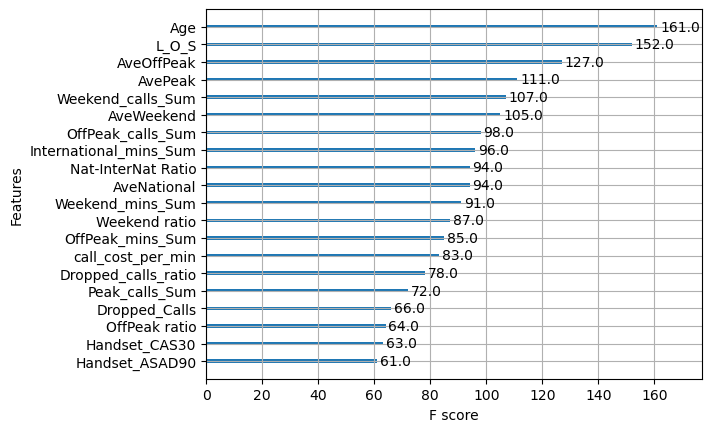

In [27]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
model_reg.get_booster().feature_names = feature_names
plot_importance(model_reg,  max_num_features=20,  title="")

<Axes: xlabel='F score', ylabel='Features'>

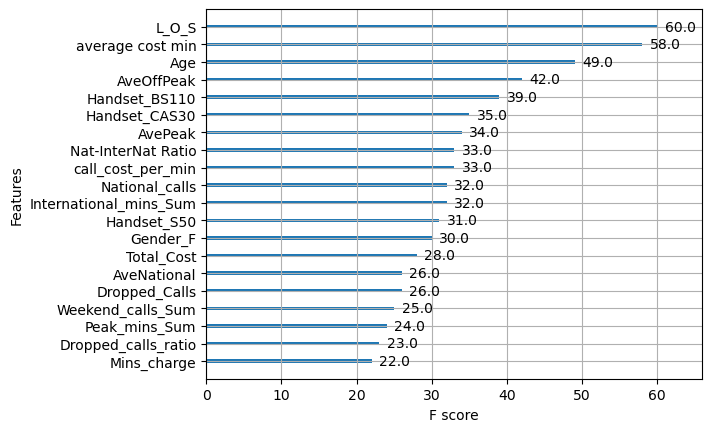

In [28]:
model_high.get_booster().feature_names = feature_names
plot_importance(model_high, max_num_features=20, title="")

<h4> Import and transform the real test data

In [32]:
df_test = pd.read_csv("../datasets/assignment1_test.csv")
#df_test.drop_duplicates(inplace=True)
#assert len(df_test.id.unique()) == len(df_test)
df_test_id=df_test["id"]
df_test_clean = df_test.drop(["id"], axis=1)

# Convert Connect date into number of days
date_test_col = pd.to_datetime(df_test_clean["Connect_Date"], format = '%d/%m/%y')
date_test_col.astype('int64')
df_test_clean["today"] = pd.Timestamp.today()
df_test_clean["Days_since_connected"] = df_test_clean["today"]-date_col
df_test_clean["Days_since_connected"] = df_test_clean["Days_since_connected"].dt.days
df_test_clean.drop(["today", "Connect_Date"], axis=1, inplace=True)

X_test =df_test_clean
X_test_raw=df_test_clean.copy()

In [33]:
y_train = y
X_train = X
X_train_raw = X_train.copy()

X_train = final_pipeline.fit_transform(X_train)
X_test= final_pipeline.transform(X_test)

<h4> Threshhold is 90th percentile of train data

In [34]:
#train_test_ratio = (X_train_raw.shape[0]/(X_test_raw.shape[0]/2))
#t = X_train_raw.join(y_train)[["average cost min", "target"]]
#t = t[t["target"] == 1]["average cost min"]
#percentile = (t.shape[0]-20*train_test_ratio)/t.shape[0]*100
#print(percentile)
percentile = 90
avg_cost_thresh = np.percentile(X_train_raw["average cost min"], percentile)
avg_cost_thresh

0.2147121

In [35]:
high_model_weight = 0.8
reg_model_weight = 1-high_model_weight
y_train_high = y_train*(X["average cost min"]>=avg_cost_thresh)

In [36]:
#combining the above with oversampling improves top 20 score
oversample = SMOTE(random_state=42)
X_train_high, y_train_high = oversample.fit_resample(X_train, y_train_high)
X_train, y_train = oversample.fit_resample(X_train, y_train)

<h4> Fit final xgb model</h4>

In [37]:
model=XGBClassifier(scale_pos_weight=6,learning_rate=0.3)

model.fit(X_train, y_train)  # Fit model to regular target
y_pred_reg = model.predict_proba(X_test)[:,1]
model.fit(X_train_high, y_train_high)  #Fit model to high value target
y_pred_high = model.predict_proba(X_test)[:,1]
y_pred = reg_model_weight*y_pred_reg + high_model_weight*y_pred_high


In [38]:
final_df = pd.concat([df_test_id,pd.Series(y_pred)], axis=1)
final_df=final_df.rename(columns = {"id":"ID", 0:"PRED"})

In [39]:
final_df.to_csv('../results/assignment1solution.csv', index=False)